# Analyzing Housing Data


Exploring a California housing data set

# Extract, Transform, Load

In [1]:
# import stuff
import os
import tarfile
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn import model_selection
from sklearn import impute
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


## Retrieve

In [2]:
# remote data source(s)
path_remote = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/"
path_remote_housing = path_remote + "housing/housing.tgz"

# define local data path 
path_local_housing = os.path.join("datasets", "housing")

In [3]:
# fetch data (tgz format)
def fetch_data_tgz(remote, local, filename):
    os.makedirs(local, exist_ok = True)
    tgz_path = os.path.join(local, filename)
    urllib.request.urlretrieve(remote, tgz_path)
    tgz_file = tarfile.open(tgz_path)
    tgz_file.extractall(path=local)
    tgz_file.close()
    
fetch_data_tgz(path_remote_housing, path_local_housing, 'housing.tgz')

In [4]:
# load dataframe (pandas)
def load_data_csv(path, filename_csv):
    csv_path = os.path.join(path, filename_csv)
    return pd.read_csv(csv_path)
    
housing = load_data_csv(path_local_housing, 'housing.csv')    


## Explore

In [5]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

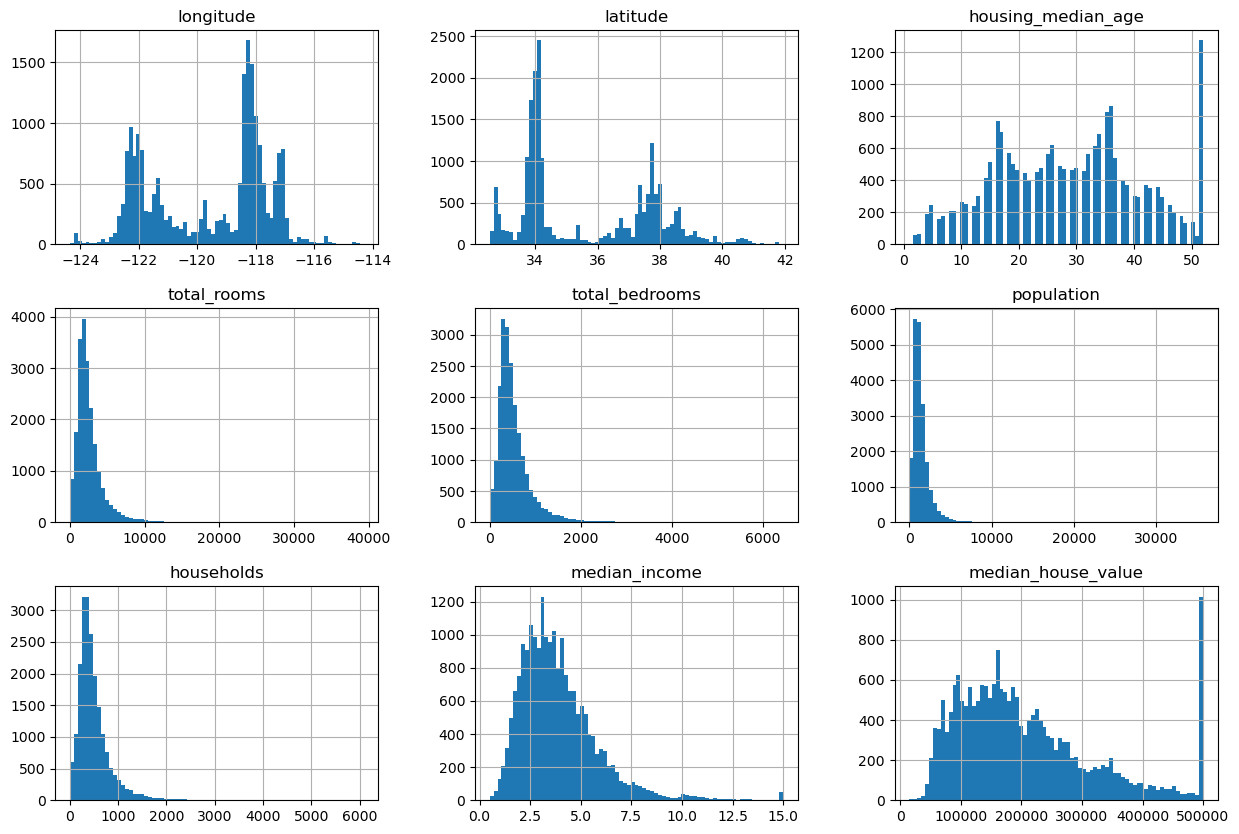

In [8]:
# plot a histogram (can be done on dataframe directly)
%matplotlib inline
housing.hist(bins=75, figsize=(15,10))
plt.show()

## Prepare

In [9]:
# split into train/test set
test_ratio = 0.2
random_seed = 42

# just a simple split (not used)
def split_data(data, test_ratio):
    if test_ratio <= 0 or test_ratio >= 1:
        raise ValueError("Select 0 < test ratio < 1")
    train_length = len(data) - int(test_ratio*len(data))
    shuffled_indices = np.random.permutation(len(data))
    train_indices = shuffled_indices[:train_length]
    test_indices = shuffled_indices[train_length:]
    return data.iloc[train_indices], data.iloc[test_indices]

# using sklearn
#train_set, test_set = model_selection.train_test_split(housing, test_size = test_ratio, random_state = random_seed)


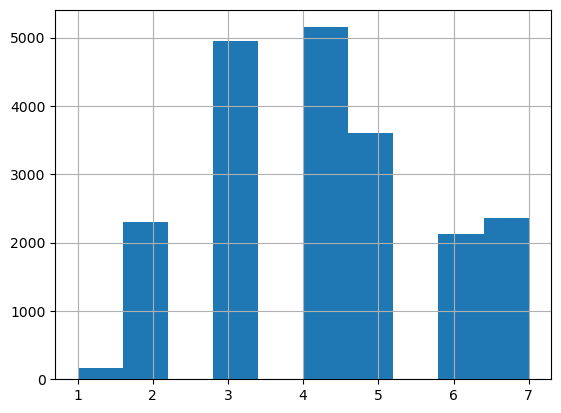

In [10]:
# lets look for imbalance in the dataset (heuristics tell us median income is important
housing['income_category'] = pd.cut(housing['median_income'], bins=[0.,1.,2.,3.,4.,5.,6.,np.inf],labels=[1,2,3,4,5,6,7])
%matplotlib inline
housing['income_category'].hist()
plt.show()

In [11]:
# we see some imbalance here, so let's try a stratified split
Split = model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = test_ratio, random_state = random_seed)
for i, j in Split.split(housing, housing['income_category']):
    train_set_stratified = housing.loc[i]
    test_set_stratified = housing.loc[j]

# compare
train_set_rand, test_set_rand = split_data(housing, test_ratio)
counts_rand = test_set_rand['income_category'].value_counts()/len(test_set_rand)
counts_strat = test_set_stratified['income_category'].value_counts()/len(test_set_stratified) 
counts_overall = housing['income_category'].value_counts()/len(housing)    
    
errors_rand = 100*(counts_overall - counts_rand)/counts_overall    
errors_strat = 100*(counts_overall - counts_strat)/counts_overall
    
comparison_table = pd.DataFrame({
    'Random Split Error (%)': errors_rand,
    'Stratified Split Error (%)': errors_strat
})

print(comparison_table.sort_index())

   Random Split Error (%)  Stratified Split Error (%)
1               11.949686                   -0.628931
2               -3.133159                   -0.087032
3                0.121310                    0.020218
4               -3.203883                    0.000000
5                3.974430                   -0.055586
6                5.265632                    0.094029
7               -1.820491                    0.084674


In [12]:
# we no longer need that income category
for each_set in (train_set_stratified, test_set_stratified):
    each_set.drop('income_category', axis = 1, inplace = True)

## Discover and Visualize 

Here we scatter plot the house value by lattitude and longitude, with the size of the dot scaling by population and a heat map of house value. 

Big cities by the coast are expensive.

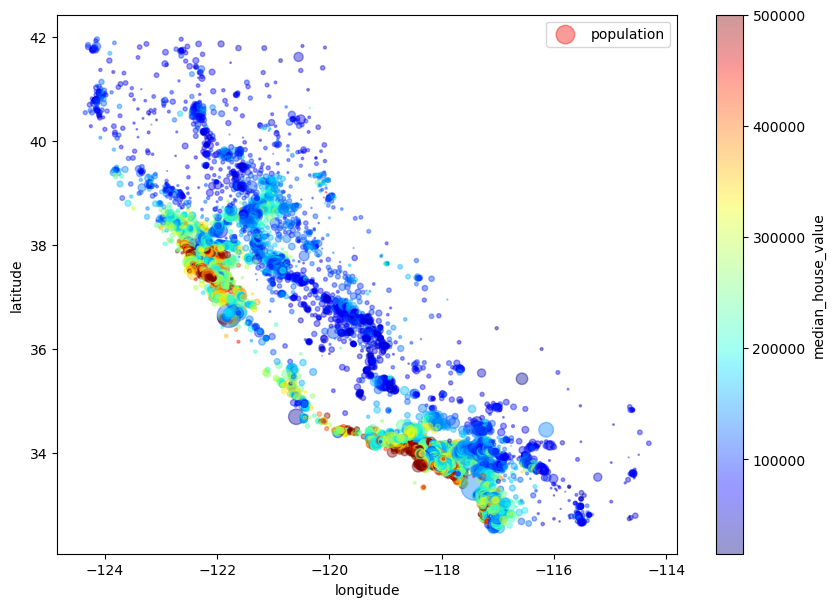

In [13]:
%matplotlib inline
housing.plot(kind='scatter', x='longitude', y='latitude', alpha = 0.4, s = housing['population']/100, label = 'population', figsize = (10,7), c= 'median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

In [14]:
#look for correlations
correlation_matrix = housing.corr(numeric_only=True)
correlation_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

From this we can infer that rich people have more expensive houses 

['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']


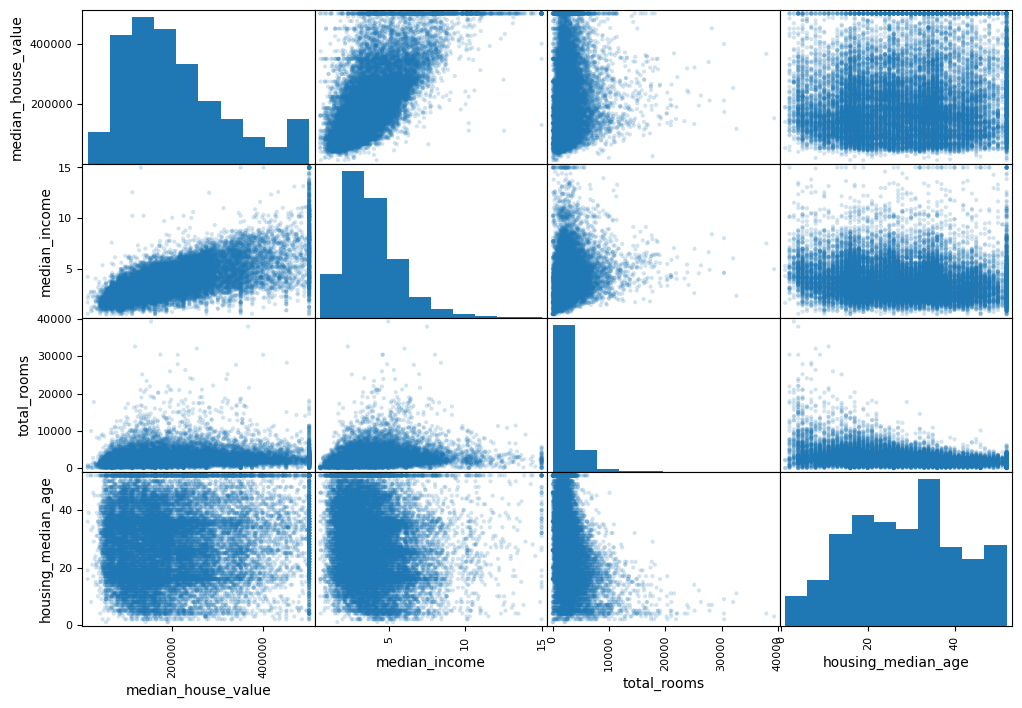

In [15]:
# pull the 4 most relevant and scatter plot them
selected_correlations = list(correlation_matrix['median_house_value'].sort_values(ascending=False).index[0:4])
print(selected_correlations)
%matplotlib inline
pd.plotting.scatter_matrix(housing[selected_correlations], alpha = 0.2, figsize=(12,8))
plt.show()

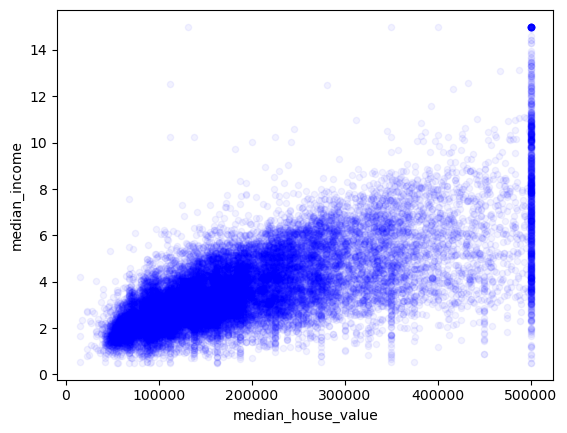

In [16]:
# strongest correlation is between median income and house value, let's zoom in
housing.plot(kind='scatter',x='median_house_value', y='median_income', alpha = 0.05, c = 'blue')
plt.show()

In [17]:
# add some potentially useful attributes
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

#examine their correlations
correlation_matrix = housing.corr(numeric_only=True)
correlation_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

## Prepare for ML

In [18]:
# features and labels
housing = train_set_stratified.drop('median_house_value', axis =1) # remove label from features
housing_labels = train_set_stratified['median_house_value'].copy() # store labels separately

In [19]:
# manually replace missing values with median
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace = True)

# try using imputer for numerical values
housing_num = housing.drop('ocean_proximity', axis = 1) # drop non-numerical attributes
imputer = impute.SimpleImputer(strategy = 'median')
imputer.fit(housing_num)
housing_tr = pd.DataFrame(imputer.transform(housing_num), 
                          columns = housing_num.columns, 
                          index = housing_num.index)

In [20]:
# deal with non-numerical values (categorical)
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

ocean_proximity
14761      NEAR OCEAN
11396       <1H OCEAN
538          NEAR BAY
12942          INLAND
18378       <1H OCEAN
5438        <1H OCEAN
2611        <1H OCEAN
17004      NEAR OCEAN
15792        NEAR BAY
9761        <1H OCEAN

In [21]:
# convert these categories into numbers
ordinal_encoder = preprocessing.OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[4.],
       [0.],
       [3.],
       [1.],
       [0.],
       [0.],
       [0.],
       [4.],
       [3.],
       [0.]])

In [22]:
print(ordinal_encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [23]:
# one-hot encoding is a preferred option
cat_encoder = preprocessing.OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print(type(housing_cat_1hot), 'of shape: ', housing_cat_1hot.shape)
# note: sparse matrix instead of np array, as this is more efficient for storing all those zeros

<class 'scipy.sparse._csr.csr_matrix'> of shape:  (16512, 5)


In [24]:
print('the sparse matrix is ', np.divide(np.count_nonzero(housing_cat_1hot.toarray() == 0),housing_cat_1hot.toarray().size)*100, '% zeros')


the sparse matrix is  80.0 % zeros


## Custom transforms

In [25]:
# selected indices
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None): # just need this to work with pipelines (duck typing constraint)
        return self
    def transform(self, X):
        rooms_per_household = X[:,rooms_ix]/X[:,households_ix]
        population_per_household = X[:,population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


## Transformation Pipelines

In [26]:
num_pipeline = Pipeline([
    ('imputer', impute.SimpleImputer(strategy = 'median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', preprocessing.StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [27]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', preprocessing.OneHotEncoder(),cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

In [28]:
housing_prepared.shape



(16512, 16)

# Train

In [29]:
# import training stuff
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

## linear regressor

In [30]:
# train a simple linear regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("predictions (lin reg): ", lin_reg.predict(some_data_prepared))
print("labels: ", list(some_labels))

predictions (lin reg):  [ 88159.98734657 319676.46019455 152439.32321276 118172.85394301
 380133.0616077 ]
labels:  [108800.0, 301800.0, 173400.0, 159800.0, 485000.0]


In [31]:
# train the whole thing and observe errors
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('rmse (lin reg): ', lin_rmse)

rmse (lin reg):  68074.16427147995


In [32]:
# underfitted. ways to fix underfitting: better model, better features, reduce constraints on model

## decision tree regressor

In [33]:
# try a more powerful model
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('rmse (dec tree reg): ', tree_rmse)

rmse (dec tree reg):  0.0


In [34]:
# probably overfitted. ways to fix overfitting: more data, regularization, cross-validation

## use cross validation

In [35]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)
tree_rmse_scores = np.sqrt(-scores)

In [36]:
def display_scores(scores):
    print('scores: ', scores)
    print('mean: ', scores.mean())
    print('std dev: ', scores.std())
    
display_scores(tree_rmse_scores)

scores:  [70863.9539115  70896.03005644 64062.68384617 67397.08204716
 73808.61417635 67851.1465274  72048.91338509 65991.97683769
 70978.32574481 69804.40295395]
mean:  69370.31294865589
std dev:  2828.284316759146


In [37]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)

In [38]:
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

scores:  [67433.27288175 68586.12057446 66025.50947973 64537.64522002
 70989.62229728 70786.46709973 69200.89140682 67505.85236922
 68186.1446749  69863.48288599]
mean:  68311.50088898958
std dev:  1935.8895394524936


## random forest regressor

In [39]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [42]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

18381.26835284224


In [45]:
#forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)
#forest_rmse_scores = np.sqrt(-forest_scores)
#display_scores(forest_rmse_scores)

# Fine-Tune model

In [53]:
# import stuff for fine-tuning
from sklearn.model_selection import GridSearchCV

## grid search

In [54]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
] # a list of dictionaries 

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [58]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [59]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [74]:
cvres = grid_search.cv_results_
cvres.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'param_bootstrap', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [80]:
for mean_score, params, rank in zip(cvres['mean_test_score'], cvres['params'], cvres['rank_test_score']):
    print(np.sqrt(-mean_score), params, 'rank:', rank)

63693.906488538785 {'max_features': 2, 'n_estimators': 3} rank: 18
54741.53756290094 {'max_features': 2, 'n_estimators': 10} rank: 11
52725.52616165728 {'max_features': 2, 'n_estimators': 30} rank: 9
59341.10908094291 {'max_features': 4, 'n_estimators': 3} rank: 15
52311.86507665446 {'max_features': 4, 'n_estimators': 10} rank: 8
50013.51379949065 {'max_features': 4, 'n_estimators': 30} rank: 3
58587.09016291128 {'max_features': 6, 'n_estimators': 3} rank: 13
51547.600987580394 {'max_features': 6, 'n_estimators': 10} rank: 5
49529.571501956256 {'max_features': 6, 'n_estimators': 30} rank: 1
58957.382861742764 {'max_features': 8, 'n_estimators': 3} rank: 14
52110.12803216939 {'max_features': 8, 'n_estimators': 10} rank: 6
49952.63277311082 {'max_features': 8, 'n_estimators': 30} rank: 2
61504.43091426709 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3} rank: 17
54036.658368029275 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10} rank: 10
59441.74080280462 {'bootstrap

In [81]:
# note: RandomizedSearchCV would be more appropriate for larger search spaces (w/ tunable n iterations)

# further analysis of features  

In [85]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.86745722e-02, 7.11381456e-02, 4.50177191e-02, 1.75111244e-02,
       1.73911868e-02, 1.77603669e-02, 1.63622651e-02, 3.19726081e-01,
       4.85104463e-02, 1.06247618e-01, 1.07390630e-01, 1.46939003e-02,
       1.30864590e-01, 1.71326871e-04, 3.34794707e-03, 5.19207985e-03])

In [92]:
extra_attribs = ['rooms_per_hhold', 'pop_per_household', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.3197260814921849, 'median_income'),
 (0.13086459024296246, 'INLAND'),
 (0.10739062978910814, 'bedrooms_per_room'),
 (0.10624761807906623, 'pop_per_household'),
 (0.07867457223800979, 'longitude'),
 (0.07113814555522806, 'latitude'),
 (0.04851044631091534, 'rooms_per_hhold'),
 (0.04501771908845523, 'housing_median_age'),
 (0.017760366904899877, 'population'),
 (0.017511124430814436, 'total_rooms'),
 (0.017391186757471516, 'total_bedrooms'),
 (0.016362265064132322, 'households'),
 (0.014693900256467123, '<1H OCEAN'),
 (0.005192079854257986, 'NEAR OCEAN'),
 (0.0033479470652321474, 'NEAR BAY'),
 (0.00017132687079440416, 'ISLAND')]

## evaluate on test set

In [109]:
final_model = grid_search.best_estimator_

X_test = test_set_stratified.drop('median_house_value', axis = 1)
y_test = test_set_stratified['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence,
                         len(squared_errors)-1, 
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)
                        )
       )


array([47335.44489417, 52002.04871342])

# Save the model

In [110]:
import joblib
my_model = final_model

# dump
joblib.dump(my_model, 'saved_models/my_model.pkl')
# load
my_model_loaded = joblib.load('saved_models/my_model.pkl')